In [ ]:
pip install torch torchvision


In [ ]:
!pip install opacus

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from opacus import PrivacyEngine
import numpy as np
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.392917
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.167277
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.964406
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.116233
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.873667
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.788012
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.766723
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.632411
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.860400
Train Epoch: 1 [28800/50000 (58%)]	Loss: 2.036875
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.709239
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.719118
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.613582
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.978268
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.770743
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.639419

 Epoch 1: Train set: Average loss: 1.8221, Mean Loss: 1.8221

 Epoch 1: Test set: Average loss: 1.5546, Mean Loss: 1.5546, Accuracy:

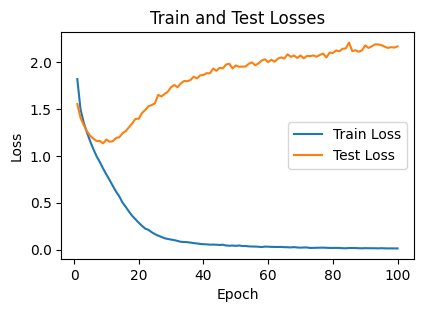

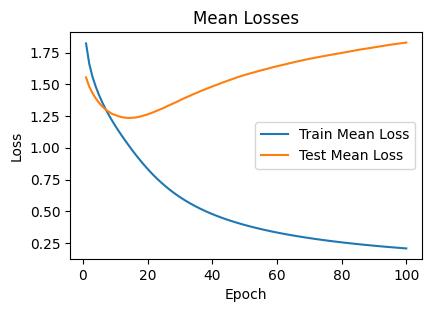

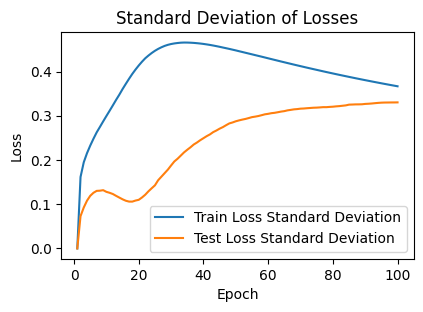

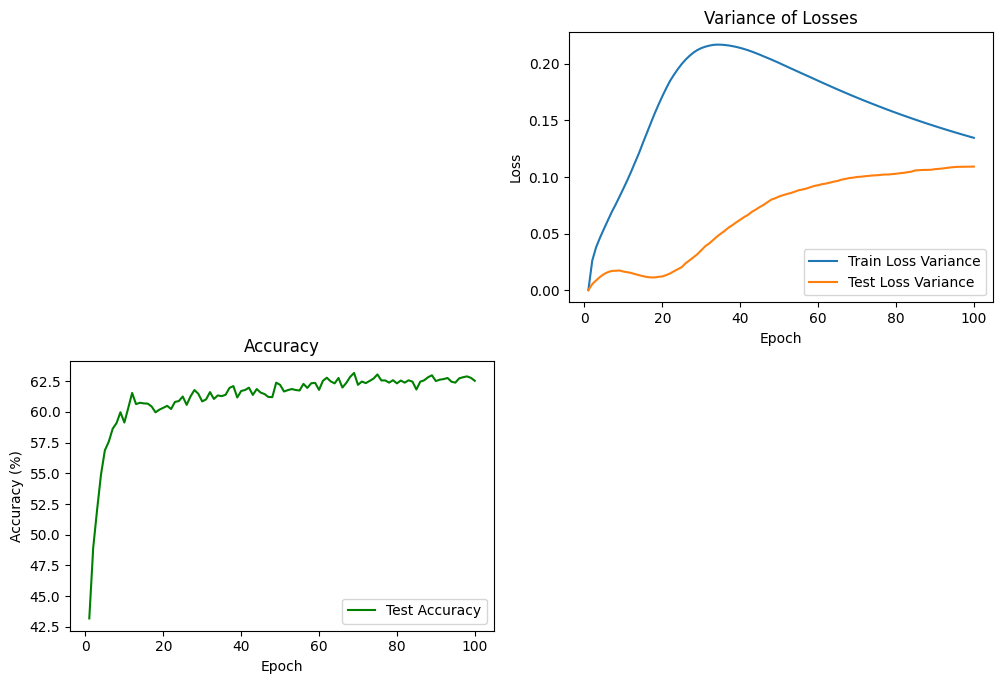

Mean train loss: 0.2081
Mean test loss: 1.8291
Standard deviation of train loss: 0.3669
Standard deviation of test loss: 0.3305
Variance of train loss: 0.1346
Variance of test loss: 0.1092
Mean accuracy: 61.2012%
Standard deviation of accuracy: 2.7333%


In [ ]:

class DifferentialPrivacyResNet(nn.Module):
    def __init__(self):
        super(DifferentialPrivacyResNet, self).__init__()
        self.resnet = resnet18(num_classes=10)

    def forward(self, x):
        return self.resnet(x)

def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return running_loss / len(train_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return test_loss / len(test_loader.dataset), correct

def calculate_statistics(losses):
    return np.mean(losses), np.std(losses), np.var(losses)

def main():
    # Data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Loading CIFAR-10 dataset
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


    # Hyperparameters
    epochs = 100
    train_losses = []
    test_losses = []
    accuracies_test = []
    #accuracies_train = []
    train_stats = {'mean': [], 'std': [], 'var': []}
    test_stats = {'mean': [], 'std': [], 'var': []}

    # Initialize model, criterion, and optimizer
    model = DifferentialPrivacyResNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Train and evaluate the model
    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, criterion, optimizer, epoch)
        test_loss, correct = test(model, test_loader, criterion)
        accuracy_test = 100. * correct / len(test_loader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies_test.append(accuracy_test)


        # Calculate statistics
        train_mean, train_std, train_var = calculate_statistics(train_losses)
        test_mean, test_std, test_var = calculate_statistics(test_losses)



         # Store statistics for plotting
        train_stats['mean'].append(train_mean)
        train_stats['std'].append(train_std)
        train_stats['var'].append(train_var)
        test_stats['mean'].append(test_mean)
        test_stats['std'].append(test_std)
        test_stats['var'].append(test_var)

        print(f'\n Epoch {epoch}: Train set: Average loss: {train_loss:.4f}, Mean Loss: {train_mean:.4f}')
        print(f'\n Epoch {epoch}: Test set: Average loss: {test_loss:.4f}, Mean Loss: {test_mean:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
              f'({accuracy_test:.2f}%)\n')


    # Plot train and test losses
    plt.figure(figsize=(10, 10))
    epochs_range = range(1, epochs + 1)
    plt.subplot(3, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Losses')
    plt.legend()

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, train_stats['mean'], label='Train Mean Loss')
    plt.plot(epochs_range, test_stats['mean'], label='Test Mean Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Mean Losses')
    plt.legend()

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 2, 3)
    plt.plot(epochs_range, train_stats['std'], label='Train Loss Standard Deviation')
    plt.plot(epochs_range, test_stats['std'], label='Test Loss Standard Deviation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Standard Deviation of Losses')
    plt.legend()

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 2, 4)
    plt.plot(epochs_range, train_stats['var'], label='Train Loss Variance')
    plt.plot(epochs_range, test_stats['var'], label='Test Loss Variance')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Variance of Losses')
    plt.legend()

    # Plot accuracy

    plt.subplot(3, 2, 5)
    plt.plot(range(1, epochs + 1), accuracies_test, color='green', label='Test Accuracy')
    #plt.plot(range(1, epochs + 1), accuracies_train, color='red', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Statistical analysis
    print(f'Mean train loss: {np.mean(train_losses):.4f}')
    print(f'Mean test loss: {np.mean(test_losses):.4f}')
    print(f'Standard deviation of train loss: {np.std(train_losses):.4f}')
    print(f'Standard deviation of test loss: {np.std(test_losses):.4f}')
    print(f'Variance of train loss: {np.var(train_losses):.4f}')
    print(f'Variance of test loss: {np.var(test_losses):.4f}')
    print(f'Mean accuracy: {np.mean(accuracies_test):.4f}%')
    print(f'Standard deviation of accuracy: {np.std(accuracies_test):.4f}%')

if __name__ == '__main__':
    main()